# Setup 



In [1]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update


apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Boost libraries
apt-get install libboost-all-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [92.1 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://security

In [2]:
!pip install vizdoom
!pip install ray 
!pip install ray['rllib']
!pip install Ipython --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.7 MB 6.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for vizdoom: filename=vizdoom-1.1.13-cp37-cp37m-linux_x86_64.whl size=14101152 sha256=3a9f3270e6430cb71b658f976a378092ae0b27fdef48b1bc8195637a8d6b0ceb
  Stored in directory: /root/.cache/pip/wheels/ac/37/ae/8e648023f66bb4c473701f94ce126032ff39ad9759ca0645a7
Successfully built vizdoom
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59.4 MB 1.4 MB/s 
     |████████████████████████████████| 8.8 MB 38.7 MB/s 
     |████████████████████████████████| 4.1 MB 42.9 MB/s 
     |████████████████████████████████| 468 kB 50.0 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.48.1
    Uni

In [1]:
import os 
from google.colab import drive
import sys

#need this to load vizdoom module 
system_path = '/content/drive/MyDrive/GitHub/INM363-Project'
drive.mount('/content/drive')
sys.path.append(system_path)

system_path = '/content/drive/MyDrive/GitHub/INM363-Project/src' 
sys.path.append(system_path)

#need this to use gpu on ray 
os.environ['PYTHONPATH'] = '/content/drive/MyDrive/GitHub/INM363-Project' 
os.environ['PYTHONPATH']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/GitHub/INM363-Project'

In [2]:
from src.vizdoom_gym.envs.VizDoomEnv import VizdoomEnv
from src.vizdoom_gym.envs.VizDoomEnv_def import VizDoomVeryDenseReward

In [3]:
from ray.tune.registry import register_env
import gym
import ray
import ray.rllib.agents.ppo as ppo
import shutil
import torch

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device, "\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

device:  cuda:0 

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Create and restore agent from checkpoint

In [5]:
ray.shutdown()
print("Shutdown ray")
# start Ray -- add `local_mode=True` here for debugging
ray.init(ignore_reinit_error=True,  num_cpus =2, num_gpus = 1) #local_mode=True,

print("Initialized ray")

# register the custom environment
select_env = "VizDoomVeryDenseReward-v0"

register_env(select_env, lambda config: VizDoomVeryDenseReward())

print("registered environment")


Shutdown ray


2022-09-19 18:54:15,106	INFO worker.py:1518 -- Started a local Ray instance.


Initialized ray
registered environment


In [6]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
config["num_workers"] = 1
config["framework"] = "torch"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['batch_mode'] = 'complete_episodes'

#changing this for evaluation time 
config['explore'] = False 
config['in_evaluation'] = True


#config["horizon"] = 50
agent = ppo.PPOTrainer(config, env=select_env)

print("created agent")

2022-09-19 18:54:22,399	INFO ppo.py:379 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-09-19 18:54:22,405	INFO algorithm.py:354 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,


(RolloutWorker pid=10370) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=10370) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/easy_dense_reward_fixed_start.wad
(RolloutWorker pid=10370) episode timeout: 800
(RolloutWorker pid=10370) screen resolution: 320X240


(RolloutWorker pid=10370) 2022-09-19 18:54:28,417	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-09-19 18:54:31,515	WARNING util.py:65 -- Install gputil for GPU system monitoring.


created agent


In [7]:
# examine the trained policy
policy = agent.get_policy()
model = policy.model


#create environment 
env = gym.make('VizDoomVeryDenseReward-v0')
#,
#               config_file="custom\\very_dense_reward.cfg",
#                scenario_file="custom/test/easy_dense_reward_rs.wad") 
#               scenario_file="custom/test/dense_reward_fixed_start.wad") 

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizdoomMyWayHome-v0
  logger.warn(f"Overriding environment {id}")
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizDoomVeryDenseReward-v0
  logger.warn(f"Overriding environment {id}")


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/easy_dense_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


In [9]:
#restore agent from checkpoint 
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense"
chkpt_dir = 'checkpoint_000100'

chkpt_file = chkpt_root + '/' + chkpt_dir 
print(chkpt_file)


/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000100


In [10]:
agent.restore(chkpt_file)

2022-09-19 18:55:07,458	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000100
2022-09-19 18:55:07,469	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5838.096105098724, '_episodes_total': 10677}


In [11]:
state = env.reset()
sum_reward = 0
n_step = 200
path = [] 

for step in range(n_step):
    action = agent.compute_action(state)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")


2022-09-19 18:55:11,721	WARNING deprecation.py:48 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


cumulative reward 11.953999999999999
total steps: 11


# Visualize Path taken by agent

Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/train/easy_dense_reward_rs.wad
Health Bonus locations: [(-512.0, 64.0), (-416.0, 64.0)]
Armor location: [(-288.0, 64.0)]
Sector locations: [(-640.0, -448.0, 160.0, 160.0), (-448.0, -640.0, -32.0, -32.0), (-640.0, -640.0, -32.0, 160.0), (-384.0, -192.0, 160.0, 160.0), (-192.0, -384.0, -32.0, -32.0), (-192.0, -192.0, 160.0, -32.0), (-384.0, -448.0, -32.0, -32.0), (-448.0, -384.0, 160.0, 160.0)]


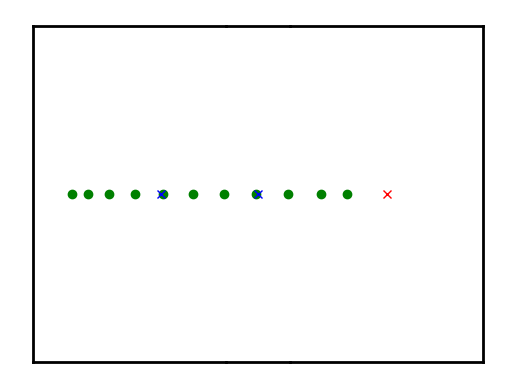

In [13]:
import src.helper_fuctions as helper

sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/train/easy_dense_reward_rs.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, path)




# average reward over all checkpoints

# Sparse Setting

In [19]:
from fnmatch import fnmatch 

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse" #_no_tpenalty"

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))

chkpt_mean_rewards = [] 



for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  agent.restore(chkpt_pth)

  num_episodes = 1
  total_reward = 0
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    sum_reward = 0
    n_step = 200

    for step in range(n_step):
          action = agent.compute_action(state)
          state, reward, done, info = env.step(action)
          sum_reward += reward

          if done == 1:
              total_reward += sum_reward 
              #print(f"total steps: {step}")
              state = env.reset()
              sum_reward = 0
              break

    if done == 0:
      total_reward += sum_reward 

    #print(total_reward)

  chkpt_mean_rewards.append(total_reward/num_episodes)


          
print(chkpt_mean_rewards)



Total number of checkpoints:  21
checkpoint_000001


2022-09-19 18:38:32,808	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000001
2022-09-19 18:38:32,815	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 87.64860653877258, '_episodes_total': 21}


checkpoint_000010


2022-09-19 18:38:35,157	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000010
2022-09-19 18:38:35,163	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 873.1147065162659, '_episodes_total': 228}


checkpoint_000020


2022-09-19 18:38:37,470	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000020
2022-09-19 18:38:37,472	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1738.2956686019897, '_episodes_total': 459}


checkpoint_000030


2022-09-19 18:38:39,758	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000030
2022-09-19 18:38:39,766	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 2604.87304520607, '_episodes_total': 695}


checkpoint_000040


2022-09-19 18:38:42,056	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000040
2022-09-19 18:38:42,060	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 3461.435373544693, '_episodes_total': 942}


checkpoint_000050


2022-09-19 18:38:44,505	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000050
2022-09-19 18:38:44,516	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 4321.420607805252, '_episodes_total': 1194}


checkpoint_000060


2022-09-19 18:38:47,754	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000060
2022-09-19 18:38:47,761	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 5180.14714717865, '_episodes_total': 1450}


checkpoint_000070


2022-09-19 18:38:51,153	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000070
2022-09-19 18:38:51,156	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 6041.6440052986145, '_episodes_total': 1697}


checkpoint_000080


2022-09-19 18:38:53,493	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000080
2022-09-19 18:38:53,497	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 6897.731177568436, '_episodes_total': 1935}


checkpoint_000090


2022-09-19 18:38:56,014	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000090
2022-09-19 18:38:56,018	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 7759.514708042145, '_episodes_total': 2179}


checkpoint_000100


2022-09-19 18:38:58,361	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000100
2022-09-19 18:38:58,363	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 8617.18613409996, '_episodes_total': 2433}


checkpoint_000110


2022-09-19 18:39:01,810	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000110
2022-09-19 18:39:01,811	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 9471.747158050537, '_episodes_total': 2681}


checkpoint_000120


2022-09-19 18:39:04,103	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000120
2022-09-19 18:39:04,105	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 10318.40287733078, '_episodes_total': 2932}


checkpoint_000130


2022-09-19 18:39:26,563	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000130
2022-09-19 18:39:26,568	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 11173.80902004242, '_episodes_total': 3179}


checkpoint_000140


2022-09-19 18:39:28,870	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000140
2022-09-19 18:39:28,872	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 12020.09320116043, '_episodes_total': 3437}


checkpoint_000150


2022-09-19 18:39:32,076	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000150
2022-09-19 18:39:32,078	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 12872.360900878906, '_episodes_total': 3684}


checkpoint_000160


2022-09-19 18:39:34,332	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000160
2022-09-19 18:39:34,334	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 13727.893499135971, '_episodes_total': 3935}


checkpoint_000170


2022-09-19 18:39:36,633	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000170
2022-09-19 18:39:36,635	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 14574.476639270782, '_episodes_total': 4197}


checkpoint_000180


2022-09-19 18:39:39,252	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000180
2022-09-19 18:39:39,255	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 15432.58521938324, '_episodes_total': 4455}


checkpoint_000190


2022-09-19 18:39:42,385	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000190
2022-09-19 18:39:42,387	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 16283.362129688263, '_episodes_total': 4713}
2022-09-19 18:39:43,413	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/sparse/checkpoint_000200
2022-09-19 18:39:43,418	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 17135.15302848816, '_episodes_total': 4984}


checkpoint_000200
[-0.8000000000000006, -0.8000000000000006, -0.8000000000000006, 0.1999999999999993, -0.8000000000000006, -0.8000000000000006, 0.1999999999999993, -0.8000000000000006, -0.8000000000000006, -0.8000000000000006, 0.1999999999999993, 0.1999999999999993, 0.1999999999999993, 0.1999999999999993, 0.1999999999999993, 0.1999999999999993, 0.1999999999999993, 0.1999999999999993, 0.1999999999999993, -0.8000000000000006, 0.1999999999999993]


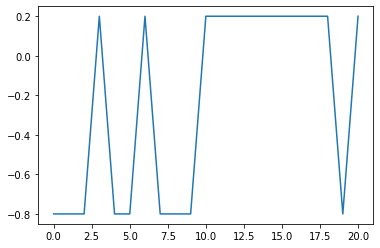

In [20]:
import matplotlib.pyplot as plt
plt.plot(chkpt_mean_rewards)
plt.show()

# Dense Setting

In [14]:
from fnmatch import fnmatch 

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense" #_no_tpenalty"

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))

chkpt_mean_rewards = [] 



for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  agent.restore(chkpt_pth)

  num_episodes = 1
  total_reward = 0
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    sum_reward = 0
    n_step = 200

    for step in range(n_step):
          action = agent.compute_action(state)
          state, reward, done, info = env.step(action)
          sum_reward += reward

          if done == 1:
              total_reward += sum_reward 
              #print(f"total steps: {step}")
              state = env.reset()
              sum_reward = 0
              break

    if done == 0:
      total_reward += sum_reward 

    #print(total_reward)

  chkpt_mean_rewards.append(total_reward/num_episodes)


          
print(chkpt_mean_rewards)



Total number of checkpoints:  31
checkpoint_000001


2022-09-19 18:46:41,023	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000001
2022-09-19 18:46:41,027	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 82.09629988670349, '_episodes_total': 20}


checkpoint_000010


2022-09-19 18:46:43,979	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000010
2022-09-19 18:46:43,981	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 824.873706817627, '_episodes_total': 221}


checkpoint_000020


2022-09-19 18:46:46,435	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000020
2022-09-19 18:46:46,438	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1640.6656866073608, '_episodes_total': 458}


checkpoint_000030


2022-09-19 18:46:49,794	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000030
2022-09-19 18:46:49,796	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 2459.9478888511658, '_episodes_total': 694}


checkpoint_000040


2022-09-19 18:46:52,617	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000040
2022-09-19 18:46:52,619	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 3272.3486638069153, '_episodes_total': 931}


checkpoint_000050


2022-09-19 18:46:55,006	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000050
2022-09-19 18:46:55,012	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 4081.1883416175842, '_episodes_total': 1160}


checkpoint_000060


2022-09-19 18:46:57,803	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000060
2022-09-19 18:46:57,805	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 4890.320251464844, '_episodes_total': 1387}


checkpoint_000070


2022-09-19 18:47:00,974	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000070
2022-09-19 18:47:00,980	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 5697.496483325958, '_episodes_total': 1617}


checkpoint_000080


2022-09-19 18:47:03,413	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000080
2022-09-19 18:47:03,415	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 6505.203742027283, '_episodes_total': 1867}


checkpoint_000090


2022-09-19 18:47:05,680	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000090
2022-09-19 18:47:05,685	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 7315.089849472046, '_episodes_total': 2117}


checkpoint_000100


2022-09-19 18:47:08,121	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000100
2022-09-19 18:47:08,123	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 8117.875114440918, '_episodes_total': 2349}


checkpoint_000110


2022-09-19 18:47:11,015	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000110
2022-09-19 18:47:11,016	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 8916.720793485641, '_episodes_total': 2589}


checkpoint_000120


2022-09-19 18:47:13,332	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000120
2022-09-19 18:47:13,335	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 9719.157001972198, '_episodes_total': 2826}


checkpoint_000130


2022-09-19 18:47:16,152	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000130
2022-09-19 18:47:16,163	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 10522.73061466217, '_episodes_total': 3068}


checkpoint_000140


2022-09-19 18:47:18,636	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000140
2022-09-19 18:47:18,642	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 11327.465673208237, '_episodes_total': 3305}


checkpoint_000150


2022-09-19 18:47:21,112	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000150
2022-09-19 18:47:21,114	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 12133.960377931595, '_episodes_total': 3544}


checkpoint_000160


2022-09-19 18:47:23,600	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000160
2022-09-19 18:47:23,602	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 12939.899189949036, '_episodes_total': 3777}


checkpoint_000170


2022-09-19 18:47:26,023	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000170
2022-09-19 18:47:26,028	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 13744.85531759262, '_episodes_total': 4019}


checkpoint_000180


2022-09-19 18:47:28,426	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000180
2022-09-19 18:47:28,429	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 14550.563561439514, '_episodes_total': 4260}


checkpoint_000190


2022-09-19 18:47:31,654	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000190
2022-09-19 18:47:31,657	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 15343.493169546127, '_episodes_total': 4490}


checkpoint_000200


2022-09-19 18:47:34,017	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000200
2022-09-19 18:47:34,019	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 16225.847374916077, '_episodes_total': 4724}


checkpoint_000220


2022-09-19 18:47:36,467	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000220
2022-09-19 18:47:36,470	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 18005.12664437294, '_episodes_total': 5204}


checkpoint_000240


2022-09-19 18:47:39,700	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000240
2022-09-19 18:47:39,704	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 19786.270585775375, '_episodes_total': 5676}


checkpoint_000260


2022-09-19 18:47:42,185	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000260
2022-09-19 18:47:42,188	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 21562.481735229492, '_episodes_total': 6154}


checkpoint_000280


2022-09-19 18:47:44,591	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000280
2022-09-19 18:47:44,593	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 23312.667819023132, '_episodes_total': 6626}


checkpoint_000300


2022-09-19 18:47:47,872	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000300
2022-09-19 18:47:47,874	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 25048.408416986465, '_episodes_total': 7096}


checkpoint_000320


2022-09-19 18:47:50,454	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000320
2022-09-19 18:47:50,456	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 320, '_timesteps_total': None, '_time_total': 26788.212993621826, '_episodes_total': 7597}


checkpoint_000340


2022-09-19 18:47:52,993	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000340
2022-09-19 18:47:52,996	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 340, '_timesteps_total': None, '_time_total': 28519.192514896393, '_episodes_total': 8091}


checkpoint_000360


2022-09-19 18:47:55,393	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000360
2022-09-19 18:47:55,396	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 360, '_timesteps_total': None, '_time_total': 30243.308764457703, '_episodes_total': 8568}


checkpoint_000380


2022-09-19 18:47:58,697	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000380
2022-09-19 18:47:58,699	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 380, '_timesteps_total': None, '_time_total': 31971.06014895439, '_episodes_total': 9055}


checkpoint_000400


2022-09-19 18:48:01,506	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense_old/checkpoint_000400
2022-09-19 18:48:01,508	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 33693.011550188065, '_episodes_total': 9542}


[-0.8000000000000006, -0.8000000000000006, 1.1999999999999993, 1.1999999999999993, -0.8000000000000006, -0.8000000000000006, -0.8000000000000006, -0.8000000000000006, -0.8000000000000006, -0.8000000000000006, 1.1999999999999993, 1.1999999999999993, 1.1999999999999993, 1.1999999999999993, -0.8000000000000006, 1.1999999999999993, 2.1999999999999993, 1.1999999999999993, 1.1999999999999993, -0.8000000000000006, -0.8000000000000006, 2.1999999999999993, -0.8000000000000006, 2.1999999999999993, -0.8000000000000006, -0.8000000000000006, 2.1999999999999993, 1.1999999999999993, 2.1999999999999993, -0.8000000000000006, -0.8000000000000006]


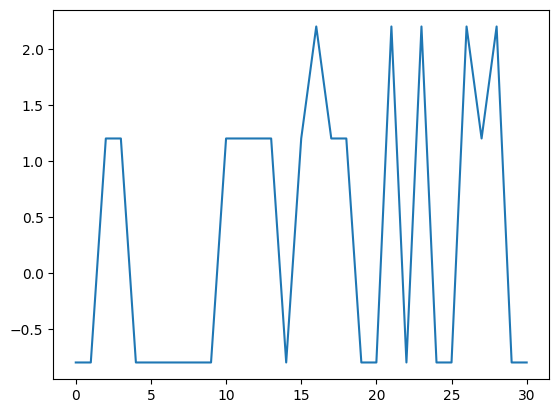

In [15]:
import matplotlib.pyplot as plt
plt.plot(chkpt_mean_rewards)
plt.show()

# Easy Dense

In [16]:
from fnmatch import fnmatch 

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense" #_no_tpenalty"

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))

chkpt_mean_rewards = [] 



for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  agent.restore(chkpt_pth)

  num_episodes = 1
  total_reward = 0
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    sum_reward = 0
    n_step = 200

    for step in range(n_step):
          action = agent.compute_action(state)
          state, reward, done, info = env.step(action)
          sum_reward += reward

          if done == 1:
              total_reward += sum_reward 
              #print(f"total steps: {step}")
              state = env.reset()
              sum_reward = 0
              break

    if done == 0:
      total_reward += sum_reward 

    #print(total_reward)

  chkpt_mean_rewards.append(total_reward/num_episodes)

          
print(chkpt_mean_rewards)

2022-09-19 18:57:40,945	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000001
2022-09-19 18:57:40,952	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 59.44102168083191, '_episodes_total': 83}


Total number of checkpoints:  21
checkpoint_000001


2022-09-19 18:57:41,287	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000005
2022-09-19 18:57:41,291	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 5, '_timesteps_total': None, '_time_total': 296.3583014011383, '_episodes_total': 351}


checkpoint_000005


2022-09-19 18:57:42,436	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000010
2022-09-19 18:57:42,437	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 598.4182868003845, '_episodes_total': 691}


checkpoint_000010
checkpoint_000015


2022-09-19 18:57:42,630	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000015
2022-09-19 18:57:42,632	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 15, '_timesteps_total': None, '_time_total': 892.4473695755005, '_episodes_total': 1069}
2022-09-19 18:57:42,808	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000020
2022-09-19 18:57:42,810	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1192.027112007141, '_episodes_total': 1462}


checkpoint_000020
checkpoint_000025


2022-09-19 18:57:43,013	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000025
2022-09-19 18:57:43,014	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 25, '_timesteps_total': None, '_time_total': 1484.3633856773376, '_episodes_total': 1910}
2022-09-19 18:57:43,174	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000030
2022-09-19 18:57:43,183	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1774.1104865074158, '_episodes_total': 2348}


checkpoint_000030
checkpoint_000035


2022-09-19 18:57:43,350	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000035
2022-09-19 18:57:43,358	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 35, '_timesteps_total': None, '_time_total': 2067.5612618923187, '_episodes_total': 2808}
2022-09-19 18:57:43,520	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000040
2022-09-19 18:57:43,525	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2358.7791702747345, '_episodes_total': 3287}


checkpoint_000040
checkpoint_000045


2022-09-19 18:57:43,697	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000045
2022-09-19 18:57:43,699	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 45, '_timesteps_total': None, '_time_total': 2649.2208490371704, '_episodes_total': 3796}
2022-09-19 18:57:43,871	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000050
2022-09-19 18:57:43,874	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 2939.0202572345734, '_episodes_total': 4345}


checkpoint_000050
checkpoint_000055


2022-09-19 18:57:44,068	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000055
2022-09-19 18:57:44,071	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 55, '_timesteps_total': None, '_time_total': 3233.047550201416, '_episodes_total': 4911}
2022-09-19 18:57:44,242	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000060
2022-09-19 18:57:44,245	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3522.411773443222, '_episodes_total': 5510}


checkpoint_000060
checkpoint_000065


2022-09-19 18:57:44,408	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000065
2022-09-19 18:57:44,410	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 65, '_timesteps_total': None, '_time_total': 3812.554979324341, '_episodes_total': 6129}
2022-09-19 18:57:44,588	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000070
2022-09-19 18:57:44,597	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 4098.073904752731, '_episodes_total': 6780}


checkpoint_000070
checkpoint_000075


2022-09-19 18:57:44,761	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000075
2022-09-19 18:57:44,763	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 75, '_timesteps_total': None, '_time_total': 4392.640350818634, '_episodes_total': 7433}
2022-09-19 18:57:44,927	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000080
2022-09-19 18:57:44,934	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 4682.901880025864, '_episodes_total': 8093}


checkpoint_000080
checkpoint_000085


2022-09-19 18:57:45,111	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000085
2022-09-19 18:57:45,114	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 85, '_timesteps_total': None, '_time_total': 4965.350474119186, '_episodes_total': 8724}
2022-09-19 18:57:45,276	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000090
2022-09-19 18:57:45,277	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 5254.580072402954, '_episodes_total': 9344}


checkpoint_000090
checkpoint_000095


2022-09-19 18:57:45,450	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000095
2022-09-19 18:57:45,453	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 95, '_timesteps_total': None, '_time_total': 5546.254445314407, '_episodes_total': 9989}
2022-09-19 18:57:45,630	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000100
2022-09-19 18:57:45,633	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5838.096105098724, '_episodes_total': 10677}


checkpoint_000100
[10.811000000000002, 1.1999999999999993, 11.943000000000001, 11.951, 11.946, 11.953999999999999, 11.953999999999999, 11.953999999999999, 11.952, 11.953999999999999, 11.952, 11.952, 11.953999999999999, 11.953999999999999, 11.953999999999999, 11.953999999999999, 11.953999999999999, 11.953999999999999, 11.953999999999999, 11.953999999999999, 11.953999999999999]


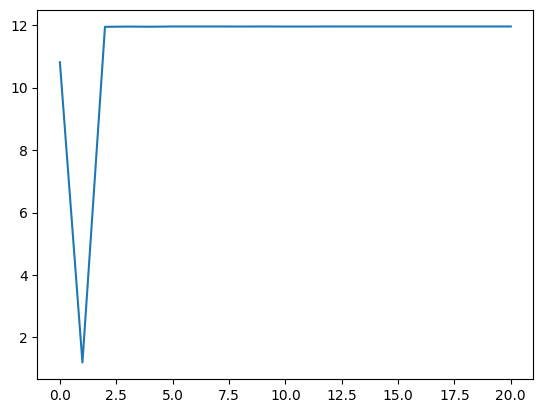

In [17]:
import matplotlib.pyplot as plt
plt.plot(chkpt_mean_rewards)
plt.show()